In [2]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from sklearn.ensemble import *
from catboost import CatBoostClassifier
import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek

In [3]:
os.chdir('..')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df=pd.read_csv('artifacts/data_transformation/train.csv')

In [6]:
df = df.loc[:, ~df.columns.str.startswith('NATURE')]

In [7]:
int_cols=df.loc[:,df.columns.str.startswith('ST_GENERAL')].columns.to_list()+(df.loc[:,df.columns.str.startswith('PRODUCT')].columns.to_list())+ (df.loc[:,df.columns.str.startswith('GENDER')].columns.to_list())
int_cols+=['AGE','A_SCORE_VALUE']

for col in int_cols:
    df[col]=df[col].astype(int)
    

In [8]:
df.head()

,ACC_NO,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,OVER_LIMIT_FEE_1,OVER_LIMIT_FEE_2,OVER_LIMIT_FEE_3,OVER_LIMIT_FEE_4,OVER_LIMIT_FEE_5,OVER_LIMIT_FEE_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,TOTAL_OS_1,TOTAL_OS_2,TOTAL_OS_3,TOTAL_OS_4,TOTAL_OS_5,TOTAL_OS_6,LATE_PAY_FEE_1,LATE_PAY_FEE_2,LATE_PAY_FEE_3,LATE_PAY_FEE_4,LATE_PAY_FEE_5,LATE_PAY_FEE_6,A_SCORE_VALUE,FINAL_LIMIT,3_MONTH_NPL_STATUS,AGE,MONTH_END_BAL_LCY,REV_SETT_1_REVOLVER,REV_SETT_1_SETTLER,REV_SETT_2_REVOLVER,REV_SETT_2_SETTLER,REV_SETT_3_REVOLVER,REV_SETT_3_SETTLER,REV_SETT_4_REVOLVER,REV_SETT_4_SETTLER,REV_SETT_5_REVOLVER,REV_SETT_5_SETTLER,REV_SETT_6_REVOLVER,REV_SETT_6_SETTLER,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdbb26,PRODUCT_Pdc921,PRODUCT_Pf4d80
0,93944.0,542.70,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12896.00,78185.72,16409.23,9008.00,0.00,0.00,3000.0,0.0,42000.0,3000.0,1000.0,2000.0,137387.06,125209.110,46277.59,65720.36,59712.36,60712.36,1750.0,0.0,0.0,0.0,0.0,0.0,194,317000.0,0.0,56,397.13,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,7238.0,7798.39,4076.19,2045.47,1551.43,7527.77,887.62,0.0,0.0,0.0,0.0,0.0,0.0,79873.03,67408.22,165612.27,87593.55,42954.06,179232.44,195000.0,51500.0,52000.0,39000.0,188200.0,22500.0,140000.80,255127.770,232021.77,117428.98,68785.43,213981.38,0.0,0.0,1750.0,0.0,0.0,0.0,217,1000000.0,0.0,35,0.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,11226.0,0.00,0.00,0.00,0.00,0.00,250.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-76.31,-76.310,-76.31,-76.31,-76.31,-76.31,0.0,0.0,0.0,0.0,0.0,0.0,231,1037000.0,0.0,55,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,94712.0,818.80,650.04,579.68,830.91,577.58,636.81,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1739.70,0.00,0.00,6314.00,13000.0,20500.0,16300.0,14500.0,20800.0,14500.0,97219.38,110219.375,130469.38,139029.67,153529.69,174329.67,0.0,0.0,0.0,0.0,0.0,0.0,233,500000.0,0.0,37,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,119466.0,570.24,618.13,602.91,250.00,250.00,250.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,42779.00,8278.68,17041.09,2238.00,0.00,15000.0,15500.0,16200.0,5500.0,3500.0,3500.0,97667.70,112667.700,85388.70,93310.02,81768.93,83030.93,0.0,0.0,0.0,0.0,0.0,1750.0,201,376000.0,0.0,56,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [9]:
df_1=df.copy()

In [10]:
df_1['OVER_LIMIT_FEE_2'].unique()

array([   0., 1750.])

In [11]:
df_1['OVER_LIMIT_FEE_1']=(df_1['OVER_LIMIT_FEE_1']>=1750).astype(int)
df_1['OVER_LIMIT_FEE_2']=(df_1['OVER_LIMIT_FEE_2']>=1750).astype(int)
df_1['OVER_LIMIT_FEE_3']=(df_1['OVER_LIMIT_FEE_3']>=1750).astype(int)
df_1['OVER_LIMIT_FEE_4']=(df_1['OVER_LIMIT_FEE_4']>=1750).astype(int)
df_1['OVER_LIMIT_FEE_5']=(df_1['OVER_LIMIT_FEE_5']>=1750).astype(int)
df_1['OVER_LIMIT_FEE_6']=(df_1['OVER_LIMIT_FEE_6']>=1750).astype(int)

df_1['LATE_PAY_FEE_1']=(df_1['LATE_PAY_FEE_1']>=1750).astype(int)
df_1['LATE_PAY_FEE_2']=(df_1['LATE_PAY_FEE_2']>=1750).astype(int)
df_1['LATE_PAY_FEE_3']=(df_1['LATE_PAY_FEE_3']>=1750).astype(int)
df_1['LATE_PAY_FEE_4']=(df_1['LATE_PAY_FEE_4']>=1750).astype(int)
df_1['LATE_PAY_FEE_5']=(df_1['LATE_PAY_FEE_5']>=1750).astype(int)
df_1['LATE_PAY_FEE_6']=(df_1['LATE_PAY_FEE_6']>=1750).astype(int)

In [12]:
df_1['REV_SETT_1'] = df_1['REV_SETT_1_REVOLVER'].apply(lambda x: 1 if x == 1 else 0)
df_1['REV_SETT_2'] = df_1['REV_SETT_2_REVOLVER'].apply(lambda x: 1 if x == 1 else 0)
df_1['REV_SETT_3'] = df_1['REV_SETT_3_REVOLVER'].apply(lambda x: 1 if x == 1 else 0)
df_1['REV_SETT_4'] = df_1['REV_SETT_4_REVOLVER'].apply(lambda x: 1 if x == 1 else 0)
df_1['REV_SETT_5'] = df_1['REV_SETT_5_REVOLVER'].apply(lambda x: 1 if x == 1 else 0)
df_1['REV_SETT_6'] = df_1['REV_SETT_6_REVOLVER'].apply(lambda x: 1 if x == 1 else 0)

df_1=df_1.drop(columns=['REV_SETT_1_REVOLVER','REV_SETT_2_REVOLVER','REV_SETT_3_REVOLVER','REV_SETT_4_REVOLVER','REV_SETT_5_REVOLVER','REV_SETT_6_REVOLVER',
                        'REV_SETT_1_SETTLER','REV_SETT_2_SETTLER','REV_SETT_3_SETTLER','REV_SETT_4_SETTLER','REV_SETT_5_SETTLER','REV_SETT_6_SETTLER'])

In [13]:
df_1['LATE_PAY_FEE']=df_1['LATE_PAY_FEE_1']+df_1['LATE_PAY_FEE_2']+df_1['LATE_PAY_FEE_3']+df_1['LATE_PAY_FEE_4']+df_1['LATE_PAY_FEE_5']+df_1['LATE_PAY_FEE_6']


df_1['OVER_LIMIT_FEE']=df_1['OVER_LIMIT_FEE_1']+df_1['OVER_LIMIT_FEE_2']+df_1['OVER_LIMIT_FEE_3']+df_1['OVER_LIMIT_FEE_4']+df_1['OVER_LIMIT_FEE_5']+df_1['OVER_LIMIT_FEE_6']

In [14]:
df_1=df_1.drop(columns=['LATE_PAY_FEE_1','LATE_PAY_FEE_2','LATE_PAY_FEE_3','LATE_PAY_FEE_4','LATE_PAY_FEE_5','LATE_PAY_FEE_6'])

df_1=df_1.drop(columns=['OVER_LIMIT_FEE_1','OVER_LIMIT_FEE_2','OVER_LIMIT_FEE_3','OVER_LIMIT_FEE_4','OVER_LIMIT_FEE_5','OVER_LIMIT_FEE_6'])

In [15]:
df_2=df_1.copy()

df_2=df_2.drop(columns=['A_SCORE_VALUE'])

In [16]:
df_3=df_2.copy()

df_3['TOTAL_OS']=(df_3['TOTAL_OS_1']+df_3['TOTAL_OS_2']+df_3['TOTAL_OS_3']+df_3['TOTAL_OS_4']+df_3['TOTAL_OS_5']+df_3['TOTAL_OS_6'])/6

df_3=df_3.drop(columns=['TOTAL_OS_1','TOTAL_OS_2','TOTAL_OS_3','TOTAL_OS_4','TOTAL_OS_5','TOTAL_OS_6','PRODUCT_Pdbb26'])

In [17]:
df1=df_3.drop(columns=['ACC_NO'])

In [18]:
x=df1.drop(columns=['3_MONTH_NPL_STATUS'])
y=df1.loc[:,['3_MONTH_NPL_STATUS']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y,shuffle=True)

In [20]:
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    print('----------------------------------------------\n')
    
    print('Train F1: {:.2f}%'.format(f1_score(y_train, train_pred) * 100))
    print('Train Precision (Class 1): {:.2f}%'.format(precision_score(y_train, train_pred) * 100))
    print('Train Recall (Class 0): {:.2f}%'.format(recall_score(y_train, train_pred,pos_label=0) * 100))
    print('Train Recall: {:.2f}%'.format(recall_score(y_train, train_pred) * 100))
    
    print('----------------------------------------------\n')
    
    conf_matrix_xgb = confusion_matrix(y_train,train_pred)
    plt.figure(figsize=(2, 2))
    sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    print('\n----------------------------------------------\n')
    test_pred = model.predict(X_test)

    
    print('Test F1: {:.2f}%'.format(f1_score(y_test, test_pred) * 100))
    print('Test Precision (Class 1): {:.2f}%'.format(precision_score(y_test, test_pred) * 100))
    print('Test Recall (Class 0): {:.2f}%'.format(recall_score(y_test, test_pred,pos_label=0) * 100))
    print('Test Recall: {:.2f}%'.format(recall_score(y_test, test_pred) * 100))
    
    print('----------------------------------------------\n')
    
    
    conf_matrix_xgb = confusion_matrix(y_test,test_pred)
    plt.figure(figsize=(2, 2))
    sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
params_xgb = {
    'scale_pos_weight': 270,
    'max_depth': 5,
    'min_child_weight': 17,
    'subsample': 0.65,
    'colsample_bytree': 0.9,
    'objective':'binary:logistic',
    'eta':0.05,
    'gamma':0.01,
    'enable_categorical': True,
    'n_estimators': 1000,
    'seed': 42,
    'alpha':0.01,
    'eval_metric':'auc'
}

params_lgb = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'scale_pos_weight': 150,
    'learning_rate': 0.05,
    'min_child_weight': 15,
    'num_leaves':75,
    'max_depth':10,
    'subsample':0.5,
    'colsample_bytree':0.9,
    'verbosity': -1,
    'n_estimators': 1000,
    'seed': 42
}

In [26]:
clf_xgb = XGBClassifier(**params_xgb)
clf_xgb.fit(X_resampled,y_resampled)

XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.05, eval_metric='auc',
              feature_types=None, gamma=0.01, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=17, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, ...)

----------------------------------------------

Train F1: 46.14%
Train Precision (Class 1): 29.99%
Train Recall (Class 0): 98.96%
Train Recall: 100.00%
----------------------------------------------



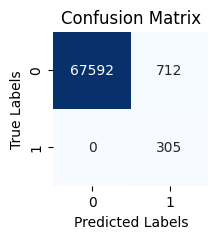


----------------------------------------------

Test F1: 11.28%
Test Precision (Class 1): 7.20%
Test Recall (Class 0): 98.50%
Test Recall: 25.95%
----------------------------------------------



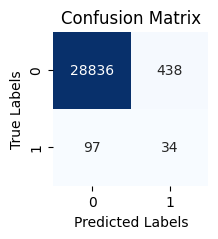

In [28]:
evaluate_model(clf_xgb, X_train, y_train, X_test, y_test)

In [29]:
clf_lgb = LGBMClassifier(**params_lgb)
clf_lgb.fit(X_resampled,y_resampled)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(boosting_type='dart', colsample_bytree=0.9, learning_rate=0.05,
               max_depth=10, min_child_weight=15, n_estimators=1000,
               num_leaves=75, objective='binary', scale_pos_weight=150, seed=42,
               subsample=0.5, verbosity=-1)

----------------------------------------------

Train F1: 57.49%
Train Precision (Class 1): 40.34%
Train Recall (Class 0): 99.34%
Train Recall: 100.00%
----------------------------------------------



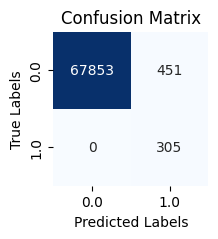


----------------------------------------------

Test F1: 14.57%
Test Precision (Class 1): 9.81%
Test Recall (Class 0): 98.84%
Test Recall: 28.24%
----------------------------------------------



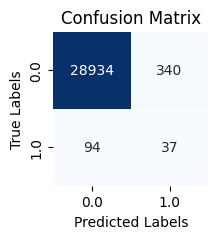

In [30]:
evaluate_model(clf_lgb, X_train, y_train, X_test, y_test)

In [35]:
estimators = [
    ('xgb', clf_xgb),
    ('lgb', clf_lgb),
]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


----------------------------------------------

Train F1: 99.35%
Train Precision (Class 1): 98.71%
Train Recall (Class 0): 99.99%
Train Recall: 100.00%
----------------------------------------------



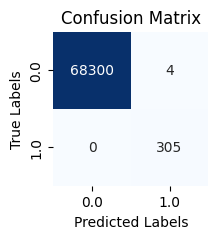


----------------------------------------------

Test F1: 14.38%
Test Precision (Class 1): 50.00%
Test Recall (Class 0): 99.96%
Test Recall: 8.40%
----------------------------------------------



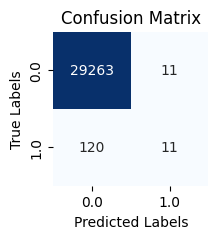

In [36]:
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train, y_train)
evaluate_model(stack, X_train, y_train, X_test, y_test)

In [32]:
pred_prob=stack.predict_proba(X_test)

In [41]:
pred_ta=(pred_prob[:,1]>=0.1).astype(int)

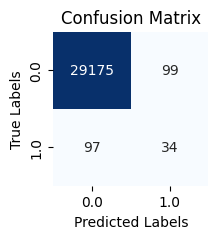

In [42]:
conf_matrix_xgb = confusion_matrix(y_test,pred_ta)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=stack.classes_, yticklabels=stack.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
bagging_classifier = BaggingClassifier(clf_lgb, n_estimators=10, random_state=42)
bagging_classifier.fit(X_train, y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(estimator=LGBMClassifier(boosting_type='dart',
                                           colsample_bytree=0.9,
                                           learning_rate=0.05, max_depth=10,
                                           min_child_weight=15,
                                           n_estimators=1000, num_leaves=75,
                                           objective='binary',
                                           scale_pos_weight=150, seed=42,
                                           subsample=0.5, verbosity=-1),
                  random_state=42)

----------------------------------------------

Train F1: 89.51%
Train Precision (Class 1): 89.51%
Train Recall (Class 0): 99.95%
Train Recall: 89.51%
----------------------------------------------



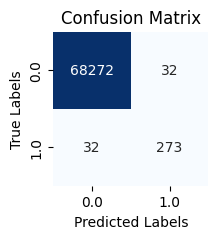


----------------------------------------------

Test F1: 21.16%
Test Precision (Class 1): 34.48%
Test Recall (Class 0): 99.87%
Test Recall: 15.27%
----------------------------------------------



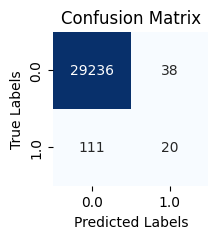

In [44]:
evaluate_model(bagging_classifier, X_train, y_train, X_test, y_test)

In [45]:
bagging_classifier = BaggingClassifier(clf_xgb, n_estimators=10, random_state=42)
bagging_classifier.fit(X_train, y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(estimator=XGBClassifier(alpha=0.01, base_score=None,
                                          booster=None, callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True, eta=0.05,
                                          eval_metric='auc', feature_types=None,
                                          gamma=0.01, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None, min_child_weight=17,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=1000, n_jobs=None, ...),
                  random_state=42)

----------------------------------------------

Train F1: 87.10%
Train Precision (Class 1): 85.71%
Train Recall (Class 0): 99.93%
Train Recall: 88.52%
----------------------------------------------



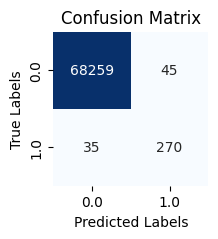


----------------------------------------------

Test F1: 20.00%
Test Precision (Class 1): 28.99%
Test Recall (Class 0): 99.83%
Test Recall: 15.27%
----------------------------------------------



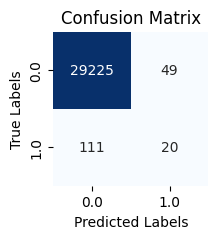

In [46]:
evaluate_model(bagging_classifier, X_train, y_train, X_test, y_test)

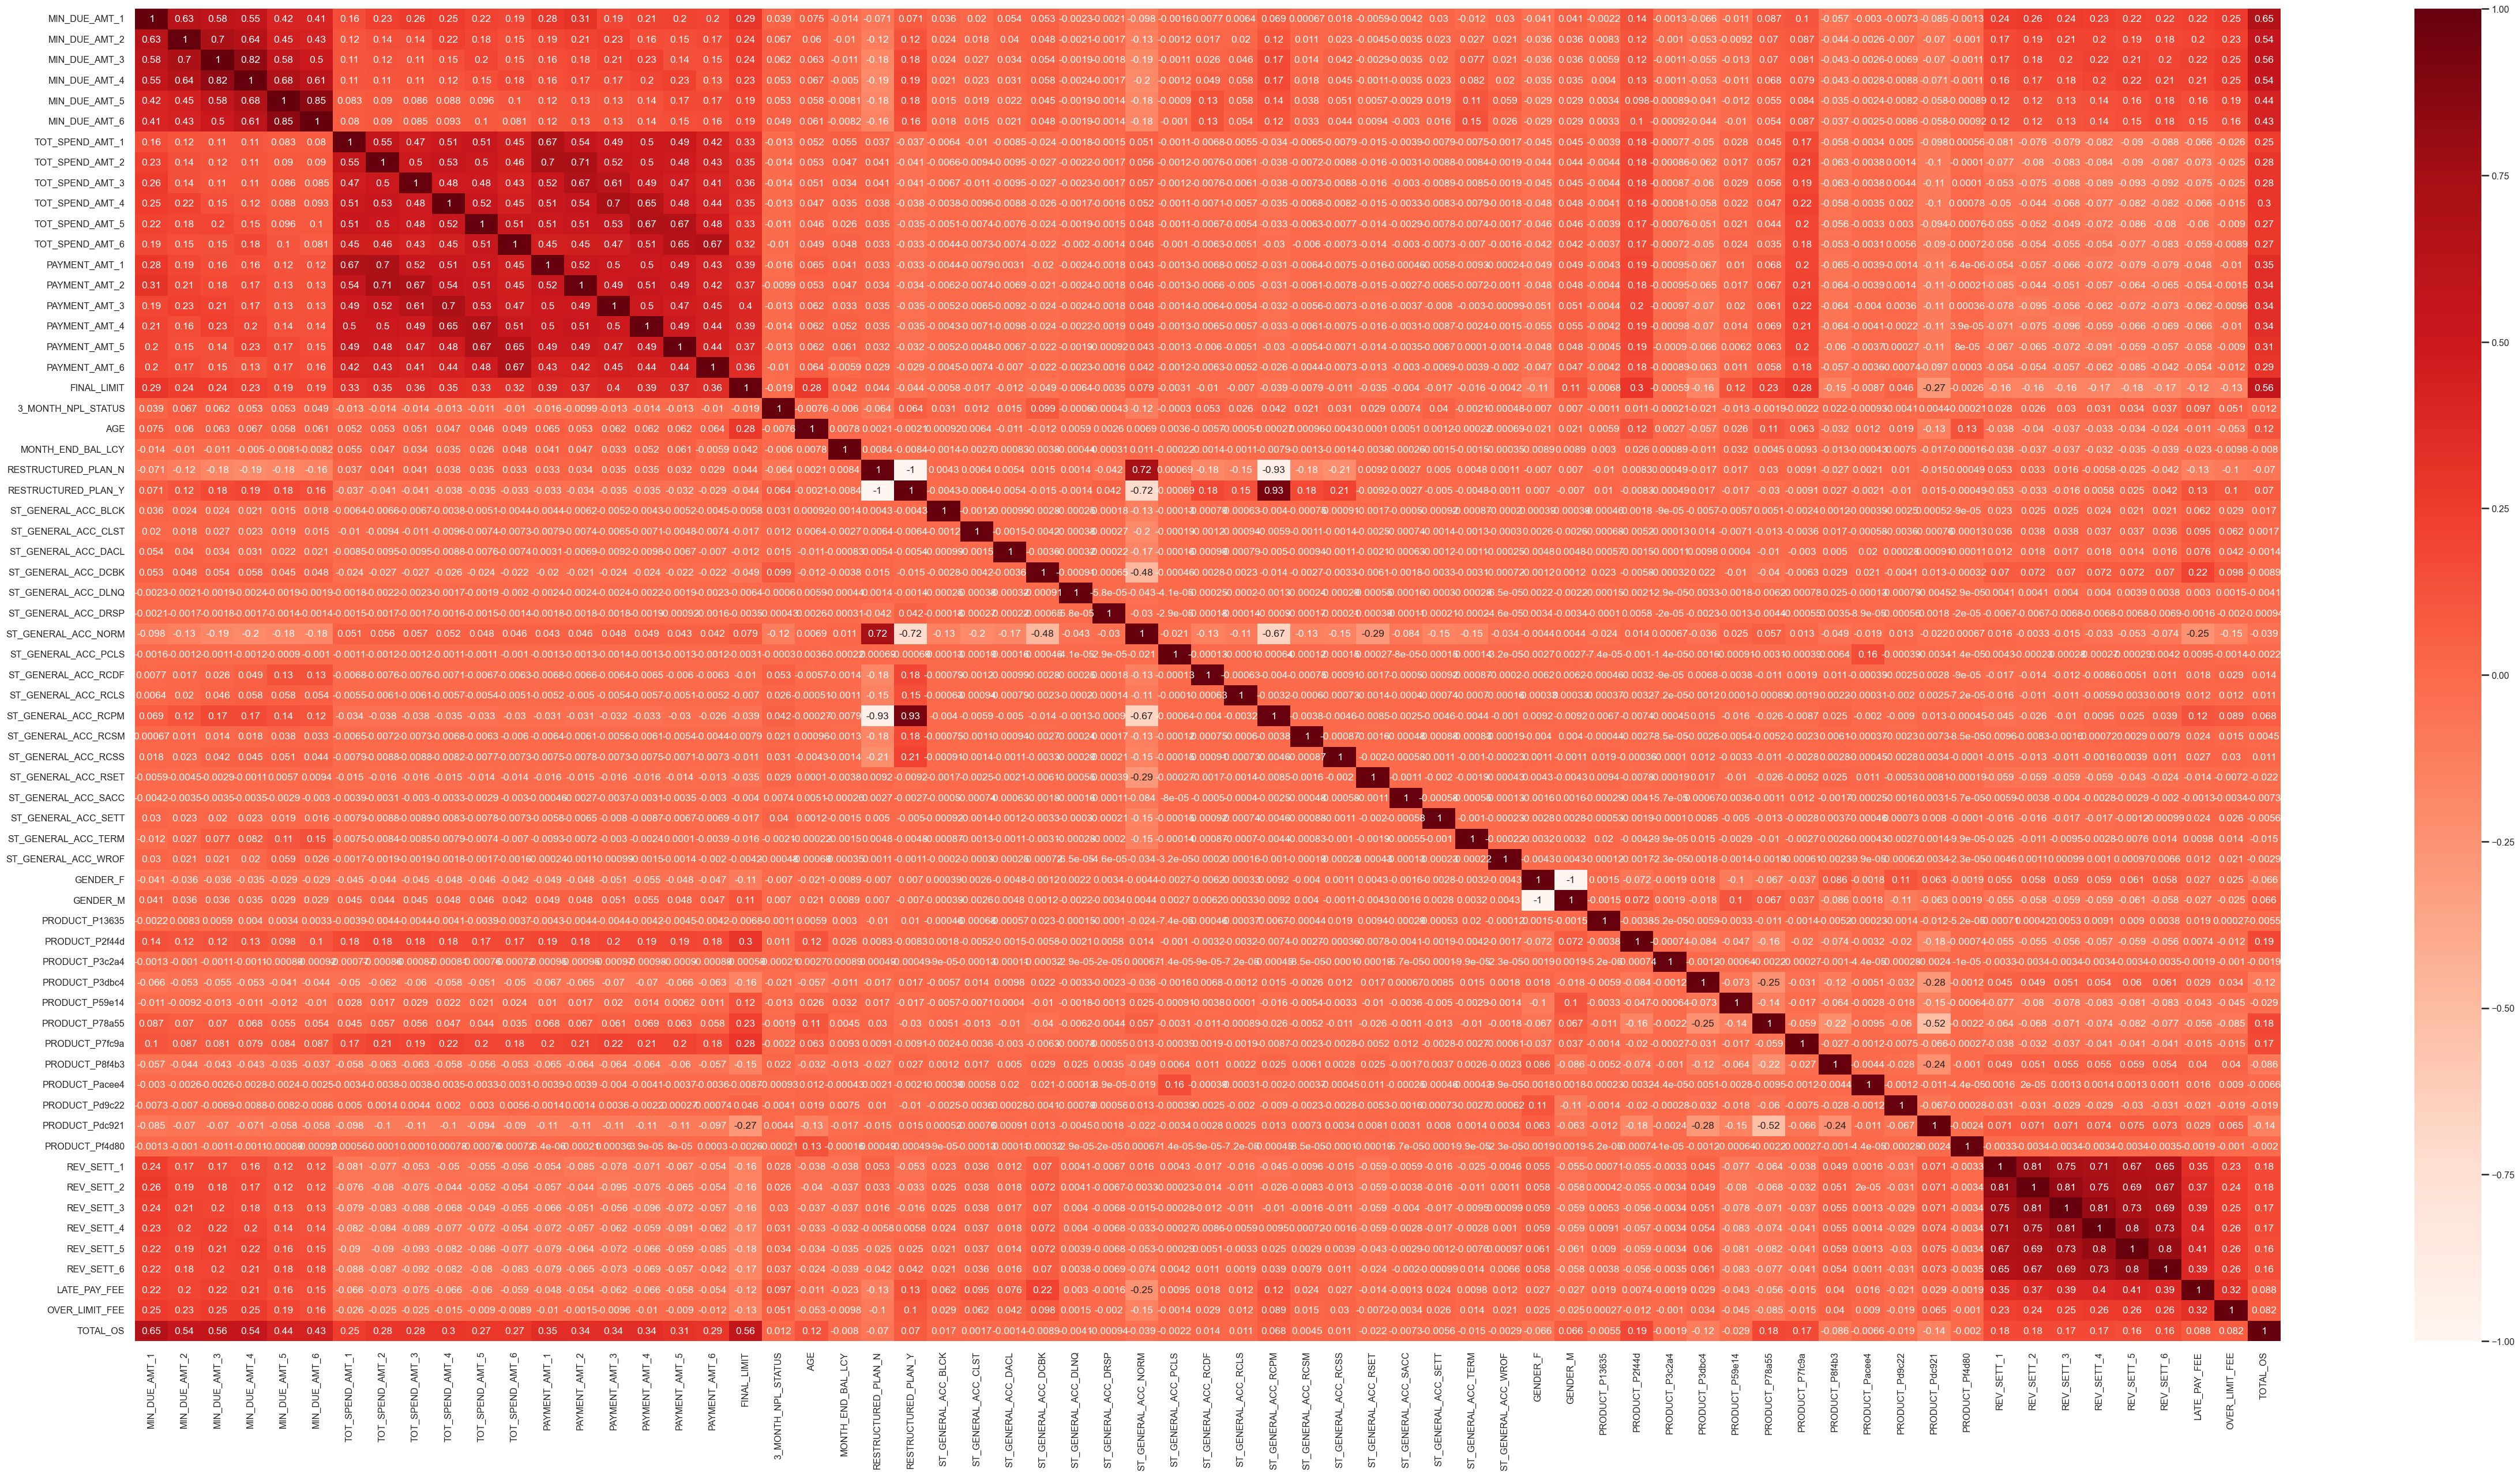

In [53]:
sns.set(rc={'figure.figsize':(60,30)})
sns.set_context("talk", font_scale=0.7)
    
sns.heatmap(df_3.iloc[:,1:].corr(), cmap='Reds', annot=True);

In [40]:
df2=X_train.copy()
df2['y_actual']=y_train

In [42]:
df2['y_pred']=clf_xgb.predict(X_train)

In [43]:
df2.head()

,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,FINAL_LIMIT,AGE,MONTH_END_BAL_LCY,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdc921,PRODUCT_Pf4d80,REV_SETT_1,REV_SETT_2,REV_SETT_3,REV_SETT_4,REV_SETT_5,REV_SETT_6,LATE_PAY_FEE,OVER_LIMIT_FEE,TOTAL_OS,y_actual,y_pred
83896,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,643000.0,38.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,-41.920000,0.0,0
69694,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,86.0,577.01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,-966.390000,0.0,0
384,7370.29,6075.91,2576.47,5249.83,2377.81,2081.01,0.00,5189.44,103400.0,52214.4,55544.37,1680.00,0.0,7380.0,8000.0,29890.0,130550.0,2400.0,300000.0,34.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,0,0,262478.870000,0.0,0
84491,11792.41,11873.80,12396.57,13244.02,14474.10,12378.91,6092.98,3406.32,0.0,7806.0,1839.62,3200.29,12000.0,15000.0,20000.0,25000.0,15000.0,12500.0,310000.0,55.0,1417.41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,0,4,312403.128333,0.0,0
50676,0.00,0.00,1141.22,776.37,479.07,250.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,49.0,4298.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,1,1,4,0,3964.321667,0.0,0


In [68]:
#df2.head()
df2[df2['y_actual']!=df2['y_pred']]

,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,FINAL_LIMIT,AGE,MONTH_END_BAL_LCY,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdc921,PRODUCT_Pf4d80,REV_SETT_1,REV_SETT_2,REV_SETT_3,REV_SETT_4,REV_SETT_5,REV_SETT_6,LATE_PAY_FEE,OVER_LIMIT_FEE,TOTAL_OS,y_actual,y_pred
86588,11168.14,10793.01,14599.29,14457.16,7667.33,4667.81,0.0,0.0,0.0,0.0,0.0,0.0,11100.0,5500.0,5400.0,9200.0,5300.0,2500.0,55000.0,30.0,5.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,6,6,57918.920000,0.0,1
40944,53928.08,43071.16,32209.71,21346.59,21285.52,21399.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59000.0,0.0,0.0,0.0,10600.0,348000.0,42.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,0,277405.635000,0.0,1
91052,0.00,250.00,0.00,0.00,0.00,250.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,0.0,0.0,0.0,800.0,50000.0,61.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1167.723333,0.0,1
97701,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,78.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,361.436667,0.0,1
91073,40038.94,31831.03,24392.91,17044.93,9771.33,10571.61,0.0,0.0,0.0,0.0,0.0,0.0,17800.0,41000.0,0.0,0.0,0.0,0.0,230000.0,43.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,5,1,208821.221667,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54079,10542.77,6990.93,3476.80,7738.28,11133.86,7573.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,10000.0,7000.0,0.0,100000.0,25.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,0,88579.216667,0.0,1
96580,1785.17,1629.13,1433.98,605.10,550.38,485.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,800.0,700.0,800.0,500.0,100000.0,30.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,0,20332.336667,0.0,1
88506,6263.59,3381.82,5541.27,2747.51,6419.07,3874.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6500.0,5000.0,0.0,0.0,6500.0,90000.0,52.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,4,0,69897.690000,0.0,1
73926,6893.73,6044.38,5159.64,4238.04,3278.04,990.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7100.0,0.0,0.0,0.0,0.0,25000.0,30.0,46322.36,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,24911.373333,0.0,1


In [64]:
df3=df2[df2['y_actual']!=df2['y_pred']].drop(columns=['y_actual','y_pred'])

In [67]:
df3

,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,FINAL_LIMIT,AGE,MONTH_END_BAL_LCY,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdc921,PRODUCT_Pf4d80,REV_SETT_1,REV_SETT_2,REV_SETT_3,REV_SETT_4,REV_SETT_5,REV_SETT_6,LATE_PAY_FEE,OVER_LIMIT_FEE,TOTAL_OS
86588,11168.14,10793.01,14599.29,14457.16,7667.33,4667.81,0.0,0.0,0.0,0.0,0.0,0.0,11100.0,5500.0,5400.0,9200.0,5300.0,2500.0,55000.0,30.0,5.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,6,6,57918.920000
40944,53928.08,43071.16,32209.71,21346.59,21285.52,21399.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59000.0,0.0,0.0,0.0,10600.0,348000.0,42.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,0,277405.635000
91052,0.00,250.00,0.00,0.00,0.00,250.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,0.0,0.0,0.0,800.0,50000.0,61.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1167.723333
97701,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000.0,78.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,361.436667
91073,40038.94,31831.03,24392.91,17044.93,9771.33,10571.61,0.0,0.0,0.0,0.0,0.0,0.0,17800.0,41000.0,0.0,0.0,0.0,0.0,230000.0,43.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,5,1,208821.221667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54079,10542.77,6990.93,3476.80,7738.28,11133.86,7573.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,10000.0,7000.0,0.0,100000.0,25.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,0,88579.216667
96580,1785.17,1629.13,1433.98,605.10,550.38,485.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,800.0,700.0,800.0,500.0,100000.0,30.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,0,20332.336667
88506,6263.59,3381.82,5541.27,2747.51,6419.07,3874.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6500.0,5000.0,0.0,0.0,6500.0,90000.0,52.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,4,0,69897.690000
73926,6893.73,6044.38,5159.64,4238.04,3278.04,990.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7100.0,0.0,0.0,0.0,0.0,25000.0,30.0,46322.36,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,24911.373333


In [45]:
import shap

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
shap.initjs()

In [47]:
explainer=shap.Explainer(clf_xgb)

In [65]:
shap_values=explainer(df3)

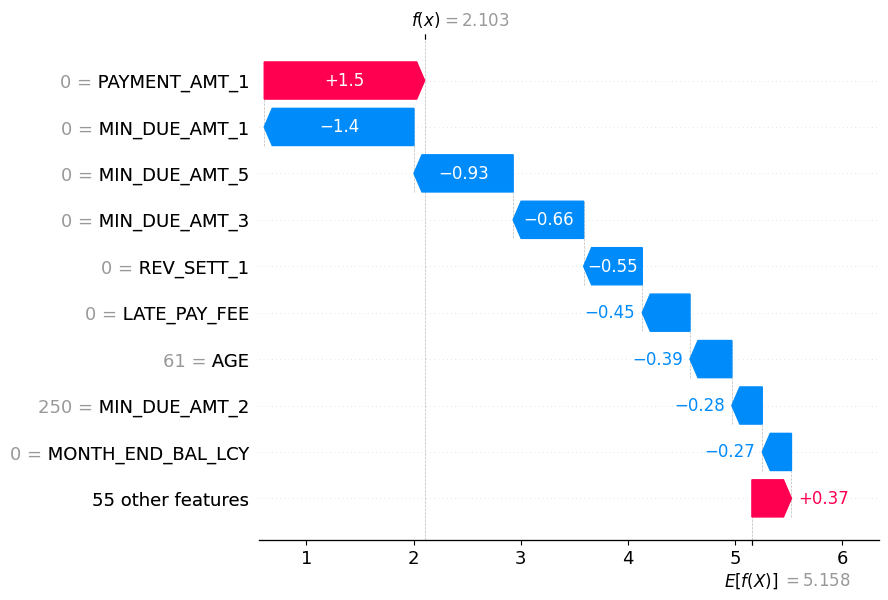

In [82]:
shap.plots.waterfall(shap_values[2])

In [78]:
df2[df2['ST_GENERAL_ACC_NORM']==0]['y_actual'].value_counts()

y_actual
0.0    2816
1.0     132
Name: count, dtype: int64

In [80]:
df2[df2['y_pred']==1]

,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,FINAL_LIMIT,AGE,MONTH_END_BAL_LCY,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdc921,PRODUCT_Pf4d80,REV_SETT_1,REV_SETT_2,REV_SETT_3,REV_SETT_4,REV_SETT_5,REV_SETT_6,LATE_PAY_FEE,OVER_LIMIT_FEE,TOTAL_OS,y_actual,y_pred
36982,390.48,123767.67,108238.01,87016.32,4882.14,2122.52,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1000.00,0.0,0.0,2700.0,2200.0,294000.0,41.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,1,1,1,4,3,385602.133333,1.0,1
91821,5282.84,3368.06,3505.80,3197.59,2741.93,3041.00,0.0,0.0,0.0,0.0,0.0,0.0,2000.00,4000.00,0.0,2000.0,1500.0,1300.0,50000.0,44.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,1,46093.305000,1.0,1
21754,2155.11,8722.65,17324.88,18002.79,14729.86,15441.82,0.0,0.0,0.0,0.0,0.0,0.0,0.00,14300.00,14300.0,14300.0,6400.0,6400.0,60000.0,49.0,0.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,5,4,55037.038333,1.0,1
13647,25597.00,26107.91,23641.23,26345.08,19068.06,11807.30,0.0,0.0,0.0,0.0,0.0,0.0,20000.00,6000.00,8000.0,5000.0,10000.0,0.0,240000.0,37.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,6,0,194300.666667,1.0,1
7305,772.84,477.42,250.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5935.43,0.0,0.0,0.0,0.0,50000.0,62.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,0,0,2,0,2978.148333,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68393,0.00,0.00,0.00,0.00,5111.45,5119.11,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,132990.0,133000.0,61.0,1182.80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,1,0,1829.613333,1.0,1
73926,6893.73,6044.38,5159.64,4238.04,3278.04,990.73,0.0,0.0,0.0,0.0,0.0,0.0,0.00,7100.00,0.0,0.0,0.0,0.0,25000.0,30.0,46322.36,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,24911.373333,0.0,1
55304,12557.29,7742.76,3489.98,2267.22,1103.76,2011.01,0.0,0.0,0.0,0.0,0.0,0.0,5079.98,8000.00,0.0,0.0,0.0,0.0,35000.0,29.0,2.56,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,1,6,3,35341.781667,1.0,1
37398,476.58,250.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,500.00,0.0,0.0,0.0,0.0,68000.0,44.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0,0,0,0,1,0,10903.920000,0.0,1
